In [1]:
from result_saver import SaverProvider
from Scratch import metadata_loader
from Scratch import find_closest_calib_jobs

import numpy as np
from tqdm import tqdm
from time import sleep
from datetime import datetime
import json
import os

from soft_info import get_noise_dict_from_backend, get_avgs_from_dict, get_repcode_IQ_map
from soft_info import RepetitionCodeStimCircuit, inv_qubit_mapping, gaussianIQConvertor
from soft_info import get_cols_to_keep, generate_subsets_with_center, get_subsample_layout
from Scratch import load_calibration_memory
from soft_info import plot_IQ_data_with_countMat
from src import cpp_soft_info as csi

def pSoftMinusOne(pSoft, estim0Mat, estim1Mat, threshold):
    pSoft_copy = pSoft.copy()
    mask = ((estim0Mat < threshold) & (estim1Mat < threshold))
    pSoft_copy[mask] = 0.5-1e-8

    # calculate the filtered ratio
    ratio = np.sum(mask) / (pSoft.shape[0]*pSoft.shape[1])
    return pSoft_copy, ratio



def decode(DEVICE, LOGICAL, XBASIS, ROUNDS, file_name, thresh1, thresh2):
    provider = SaverProvider()

    state = "X" if XBASIS else "Z"
    state += LOGICAL
    print(f"state = {state}")


    # Load the metadata
    while True:
        try:
            md = metadata_loader(True, True)
            break
        except:
            sleep(5)
    md = md[md["job_status"] == "JobStatus.DONE"]
    md = md[md["code"] == "RepetitionCodeCircuit"]
    md = md[md["descr"] == 'subset RepCodes']
    md = md.dropna(subset=["rounds"])
    md = md[md["meas_level"] == 1]
    md['rounds'] = md['rounds'].astype(int)
    md['distance'] = md['distance'].astype(int)

    md = md[md["backend_name"] == DEVICE]
    md = md[md["logical"] == LOGICAL]
    md = md[md["xbasis"] == XBASIS]
    md = md[md["rounds"] == ROUNDS]

    print("shape:", md.shape)
    
    # md = md[:1]

    DOUBLE_MSMT = False # to get also 03-16

    jobs_by_calibration_date = {}
    for index, row in md.iterrows():
        job_id = row['job_id']

        while True:
            try:
                _, _, calib_creation_date = find_closest_calib_jobs(tobecalib_job=job_id, verbose=False, double_msmt=DOUBLE_MSMT)
                break
            except:
                sleep(5)

        if calib_creation_date not in jobs_by_calibration_date.keys():
            jobs_by_calibration_date[calib_creation_date] = [job_id]
        else:
            jobs_by_calibration_date[calib_creation_date].append(job_id)

    print(jobs_by_calibration_date)
    print()
    print(f"num of calibrations: {len(jobs_by_calibration_date)}")
    print(f"num of jobs per calibration: {([len(jobs) for jobs in jobs_by_calibration_date.values()])}")


    d = md["distance"].values[0]

    distances = np.arange(7, d+1, 4)
    distances = distances[::-1]

    rel_error = 1
    _RESETS = False

    # KDE BANDWIDTHS
    lin = [0.6, 1.2, 1]
    num_points = 20
    # lin = [0.1, 0.7, 1]
    # num_points = 7
    bandwidths = np.linspace(lin[0], lin[1], lin[2])


    for calib_date in jobs_by_calibration_date.keys():
        # get the noise dict of that date
        noise_dict = get_noise_dict_from_backend(provider, DEVICE, date = calib_date)

        # get the KDE of that date

        while True:
            try:
                all_memories, gmm_dict, _ = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                            other_date=calib_date, post_process=True,
                                                                            double_msmt=False)
                break
            except:
                sleep(5)

        kde_dict = csi.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

        while True:
            try:
                all_memories_PS, gmm_dict_PS, msmt_err_dict_PS = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                                other_date=calib_date, post_process=True,
                                                                                double_msmt=True)
                break
            except:
                sleep(5)
        kde_dict_PS = csi.get_KDEs(all_memories_PS, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

        # Get the mean msmt errors
        p_soft_mean = 0
        p_hard_mean = 0
        for key, value in msmt_err_dict_PS.items():
            p_soft_mean += value['p_soft']
            p_hard_mean += value['p_hard']
        p_soft_mean /= len(msmt_err_dict_PS)
        p_hard_mean /= len(msmt_err_dict_PS)
        print(msmt_err_dict_PS, p_soft_mean, p_hard_mean)

        for i in range(127):
            print(f"qubit {i}: {kde_dict[i].bestBandwidth}", end=' ')
        print("\nPS", end=' ')
        for i in range(127):
            print(f"qubit {i}: {kde_dict_PS[i].bestBandwidth}", end=' ')

        # Retrieve the memories
        memories = []
        for job_id in tqdm(jobs_by_calibration_date[calib_date], desc=f"Retrieving jobs of {calib_date} calibration"):
            d = md[md["job_id"] == job_id]["distance"].values[0] 
            T = md[md["job_id"] == job_id]["rounds"].values[0] # Should be 10

            # Get the job
            job = provider.retrieve_job(job_id)
            memory = job.result().get_memory()
            memories.append(memory)

        # Stack the memories vertically
        big_memory = np.vstack(memories)

        # Get the layout of the last job (same as previous)
        layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
        link_qubits = list(layout_des['link_qubit'].values())
        code_qubits = list(layout_des['code_qubit'].values())

        # Get the pSoft and countMat matrices
        big_layout = link_qubits + code_qubits
        inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

        print(f"Starting to get pSoft and countMat at {datetime.now()}")
        pSoft, countMat, estim0Mat, estim1Mat = csi.iqConvertorEstim(big_memory, inverted_q_map, kde_dict, rel_error, -1)
        
        print(f"Starting to get pSoft_PS and countMat_PS at {datetime.now()}")
        pSoft_PS, countMat_PS, estim0MatPS, estim1MatPS = csi.iqConvertorEstim(big_memory, inverted_q_map, kde_dict_PS, rel_error, -1)

        # Post select the leakage
        pSoft_1, ratio_1 = pSoftMinusOne(pSoft, estim0Mat, estim1Mat, threshold=thresh1)
        pSoft_PS_1, ratio_PS_1 = pSoftMinusOne(pSoft_PS, estim0MatPS, estim1MatPS, threshold=thresh1)
        pSoft_5, ratio_5 = pSoftMinusOne(pSoft, estim0Mat, estim1Mat, threshold=thresh2)
        pSoft_PS_5, ratio_PS_5 = pSoftMinusOne(pSoft_PS, estim0MatPS, estim1MatPS, threshold=thresh2)

        # Plot qubits
        for qubit in [3, 69]:
            cols = inverted_q_map[qubit]
            mask_1 = (pSoft_1[:, cols] == 0.5-1e-8)
            maskPS_1 = (pSoft_PS_1[:, cols] == 0.5-1e-8)
            mask_2 = (pSoft_5[:, cols] == 0.5-1e-8)
            maskPS_2 = (pSoft_PS_5[:, cols] == 0.5-1e-8)
            print(f"sum mask_1: {np.sum(mask_1)}")
            print(f"sum maskPS_1: {np.sum(maskPS_1)}")
            print(f"sum mask_2: {np.sum(mask_2)}")
            print(f"sum maskPS_2: {np.sum(maskPS_2)}")
            plot_IQ_data_with_countMat(big_memory[:, cols][mask_1], countMat[:, cols][mask_1], title=f"not PS | qubit {qubit}, state {state}, threshold {thresh1:.0%}")
            plot_IQ_data_with_countMat(big_memory[:, cols][maskPS_1], countMat_PS[:, cols][maskPS_1], title=f"PS | qubit {qubit}, state {state}, threshold {thresh1:.0%}")
            plot_IQ_data_with_countMat(big_memory[:, cols][mask_2], countMat[:, cols][mask_2], title=f"not PS | qubit {qubit}, state {state}, threshold {thresh2:.0%}")
            plot_IQ_data_with_countMat(big_memory[:, cols][maskPS_2], countMat_PS[:, cols][maskPS_2], title=f"PS | qubit {qubit}, state {state}, threshold {thresh2:.0%}")


        assert pSoft.shape[0] == pSoft_PS.shape[0] , "Different number of shots for each decoding method"
        NB_SHOTS = pSoft.shape[0]

        # Subsample decoding
        for D_NEW in tqdm(distances):
            subsets = generate_subsets_with_center(d, D_NEW)


            err_s_K_mean_1 = []
            err_s_K_indiv_1 = []
            err_s_K_mean_5 = []
            err_s_K_indiv_5 = []
            err_h_K_indiv = []
            err_h_K_mean = []
            err_h_K_mean_1 = []
            err_h_K_mean_5 = []

            err_s_KPS_mean_1 = []
            err_s_KPS_indiv_1 = []
            err_s_KPS_mean_5 = []
            err_s_KPS_indiv_5 = []
            err_h_KPS_indiv = []
            err_h_KPS_mean = []
            err_h_KPS_mean_1 = []
            err_h_KPS_mean_5 = []

            for subset in (subsets):             
                cols_to_keep = get_cols_to_keep(subset, T, d)

                # Get the subset of pSoft and countMat
                pSoft_sub_1 = pSoft_1[:, cols_to_keep]
                pSoft_PS_sub_1 = pSoft_PS_1[:, cols_to_keep]
                pSoft_sub_5 = pSoft_5[:, cols_to_keep]
                pSoft_PS_sub_5 = pSoft_PS_5[:, cols_to_keep]
                countMat_sub = countMat[:, cols_to_keep]
                countMat_PS_sub = countMat_PS[:, cols_to_keep]


                # Means for hard decoding
                pSoft_mean_1 = np.mean(pSoft_sub_1)
                pSoft_PS_mean_1 = np.mean(pSoft_PS_sub_1)
                pSoft_mean_5 = np.mean(pSoft_sub_5)
                pSoft_PS_mean_5 = np.mean(pSoft_PS_sub_5)

                # Get the layout
                layout = get_subsample_layout(subset, link_qubits, code_qubits)

                # Get the noise avgs
                avgs = get_avgs_from_dict(noise_dict, layout)
                noise_list = [avgs["two_gate"], avgs["single_gate"], avgs["t1_err"], avgs["t2_err"]]
                readout = avgs["readout"]
                noise_list += [(p_hard_mean+p_soft_mean), p_hard_mean, p_soft_mean]
                #[twog_err, sglg_err, t1_err, t2_err, readout_err, hard_err, soft_err]

                # Stim models
                subsampling = (D_NEW != d)

                code_indiv_for_soft = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=noise_list,
                                                                subsampling=subsampling, no_fin_soft=True, layout=layout,
                                                                msmt_err_dict=msmt_err_dict_PS)
                model_indiv_for_soft = code_indiv_for_soft.circuits[LOGICAL].detector_error_model()

                code_indiv_for_hard = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=noise_list,
                                                                subsampling=subsampling, no_fin_soft=False, layout=layout,
                                                                msmt_err_dict=msmt_err_dict_PS)
                model_indiv_for_hard = code_indiv_for_hard.circuits[LOGICAL].detector_error_model()

                code_mean_for_soft = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=noise_list,
                                                                subsampling=subsampling, no_fin_soft=True, layout=None,
                                                                msmt_err_dict=None)
                model_mean_for_soft = code_mean_for_soft.circuits[LOGICAL].detector_error_model()

                code_mean_for_hard = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=noise_list,
                                                                subsampling=subsampling, no_fin_soft=False, layout=None,
                                                                msmt_err_dict=None)
                model_mean_for_hard = code_mean_for_hard.circuits[LOGICAL].detector_error_model()
                

                # Decoding
                
                ### KDE
                res_s_K_mean_1 = csi.decodeConvertorAll(model_mean_for_soft, countMat_sub, pSoft_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_K_mean_5 = csi.decodeConvertorAll(model_mean_for_soft, countMat_sub, pSoft_sub_5, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_K_indiv_1 = csi.decodeConvertorAll(model_indiv_for_soft, countMat_sub, pSoft_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_K_indiv_5 = csi.decodeConvertorAll(model_indiv_for_soft, countMat_sub, pSoft_sub_5, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)

                res_h_K_indiv = csi.decodeConvertorAll(model_indiv_for_hard, countMat_sub, pSoft_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=True)
                res_h_K_mean = csi.decodeConvertorAll(model_mean_for_hard, countMat_sub, pSoft_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=True)
                
                new_noise_list = noise_list.copy()
                new_noise_list[-1] = pSoft_mean_1
                code_mean_1 = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=new_noise_list,
                                                            subsampling=subsampling, no_fin_soft=False, layout=None,
                                                            msmt_err_dict=None)
                model_mean_1 = code_mean_1.circuits[LOGICAL].detector_error_model()
                res_h_K_mean_1 = csi.decodeConvertorAll(model_mean_1, countMat_sub, pSoft_sub_1, T,
                                                            int(LOGICAL), _RESETS, decode_hard=True)
                
                new_noise_list = noise_list.copy()
                new_noise_list[-1] = pSoft_mean_5
                code_mean_5 = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=new_noise_list,
                                                            subsampling=subsampling, no_fin_soft=False, layout=None,
                                                            msmt_err_dict=None)
                model_mean_5 = code_mean_5.circuits[LOGICAL].detector_error_model()
                res_h_K_mean_5 = csi.decodeConvertorAll(model_mean_5, countMat_sub, pSoft_sub_5, T,
                                                            int(LOGICAL), _RESETS, decode_hard=True)
                
                
                ### KDE PS
                res_s_KPS_mean_1 = csi.decodeConvertorAll(model_mean_for_soft, countMat_PS_sub, pSoft_PS_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_KPS_mean_5 = csi.decodeConvertorAll(model_mean_for_soft, countMat_PS_sub, pSoft_PS_sub_5, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_KPS_indiv_1 = csi.decodeConvertorAll(model_indiv_for_soft, countMat_PS_sub, pSoft_PS_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)
                res_s_KPS_indiv_5 = csi.decodeConvertorAll(model_indiv_for_soft, countMat_PS_sub, pSoft_PS_sub_5, T,
                                                        int(LOGICAL), _RESETS, decode_hard=False)

                res_h_KPS_indiv = csi.decodeConvertorAll(model_indiv_for_hard, countMat_PS_sub, pSoft_PS_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=True)
                res_h_KPS_mean = csi.decodeConvertorAll(model_mean_for_hard, countMat_PS_sub, pSoft_PS_sub_1, T,
                                                        int(LOGICAL), _RESETS, decode_hard=True)
                
                new_noise_list = noise_list.copy()
                new_noise_list[-1] = pSoft_PS_mean_1
                code_mean_1 = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=new_noise_list,
                                                            subsampling=subsampling, no_fin_soft=False, layout=None,
                                                            msmt_err_dict=None)
                model_mean_1 = code_mean_1.circuits[LOGICAL].detector_error_model()
                res_h_KPS_mean_1 = csi.decodeConvertorAll(model_mean_1, countMat_PS_sub, pSoft_PS_sub_1, T,
                                                            int(LOGICAL), _RESETS, decode_hard=True)
                
                new_noise_list = noise_list.copy()
                new_noise_list[-1] = pSoft_PS_mean_5
                code_mean_5 = RepetitionCodeStimCircuit(D_NEW, T, XBASIS, _RESETS, noise_list=new_noise_list,
                                                            subsampling=subsampling, no_fin_soft=False, layout=None,
                                                            msmt_err_dict=None)
                model_mean_mean = code_mean_5.circuits[LOGICAL].detector_error_model()
                res_h_KPS_mean_5 = csi.decodeConvertorAll(model_mean_mean, countMat_PS_sub, pSoft_PS_sub_5, T,
                                                            int(LOGICAL), _RESETS, decode_hard=True)
                
                # Append the results
                err_s_K_mean_1.append(res_s_K_mean_1.num_errors)
                err_s_K_mean_5.append(res_s_K_mean_5.num_errors)
                err_s_K_indiv_1.append(res_s_K_indiv_1.num_errors)
                err_s_K_indiv_5.append(res_s_K_indiv_5.num_errors)
                err_h_K_indiv.append(res_h_K_indiv.num_errors)
                err_h_K_mean.append(res_h_K_mean.num_errors)
                err_h_K_mean_1.append(res_h_K_mean_1.num_errors)
                err_h_K_mean_5.append(res_h_K_mean_5.num_errors)
                
                err_s_KPS_mean_1.append(res_s_KPS_mean_1.num_errors)
                err_s_KPS_mean_5.append(res_s_KPS_mean_5.num_errors)
                err_s_KPS_indiv_1.append(res_s_KPS_indiv_1.num_errors)
                err_s_KPS_indiv_5.append(res_s_KPS_indiv_5.num_errors)
                err_h_KPS_indiv.append(res_h_KPS_indiv.num_errors)
                err_h_KPS_mean.append(res_h_KPS_mean.num_errors)
                err_h_KPS_mean_1.append(res_h_KPS_mean_1.num_errors)
                err_h_KPS_mean_5.append(res_h_KPS_mean_5.num_errors)


            # Save the results
        

            json_KDE = {
                "decoding": "kde",
                "d_new": str(D_NEW),
                "error_list_dict": {
                    'soft_mean_thresh_1': err_s_K_mean_1,
                    'soft_mean_thresh_2': err_s_K_mean_5,
                    'soft_indiv_thresh_1': err_s_K_indiv_1,
                    'soft_indiv_thresh_2': err_s_K_indiv_5,
                    'hard_indiv': err_h_K_indiv,
                    'hard_mean': err_h_K_mean,
                    'hard_mean_thresh_1': err_h_K_mean_1,
                    'hard_mean_thresh_2': err_h_K_mean_5,
                },
                "error_mean_dict": {
                    'soft_mean_thresh_1': np.mean(err_s_K_mean_1),
                    'soft_mean_thresh_2': np.mean(err_s_K_mean_5),
                    'soft_indiv_thresh_1': np.mean(err_s_K_indiv_1),
                    'soft_indiv_thresh_2': np.mean(err_s_K_indiv_5),
                    'hard_indiv': np.mean(err_h_K_indiv),
                    'hard_mean': np.mean(err_h_K_mean),
                    'hard_mean_thresh_1': np.mean(err_h_K_mean_1),
                    'hard_mean_thresh_2': np.mean(err_h_K_mean_5),
                },   
                "additional_info": {
                    "rel_error": rel_error,
                    "bandwidth_linspace": lin,
                    "num_points_bandwidths": num_points,
                    'threshold_1': thresh1,
                    'threshold_2': thresh2,
                    'pSoft_mean_thresh_1': pSoft_mean_1,
                    'pSoft_mean_thresh_2': pSoft_mean_5,
                    'ratio_leaked_1': ratio_1,
                    'ratio_leaked_2': ratio_5,
                },        
            }

            json_KDE_PS = {
                "decoding": "kde_PS",
                "d_new": str(D_NEW),
                "error_list_dict": {
                    'soft_mean_thresh_1': err_s_KPS_mean_1,
                    'soft_mean_thresh_2': err_s_KPS_mean_5,
                    'soft_indiv_thresh_1': err_s_KPS_indiv_1,
                    'soft_indiv_thresh_2': err_s_KPS_indiv_5,
                    'hard_indiv': err_h_KPS_indiv,
                    'hard_mean': err_h_KPS_mean,
                    'hard_mean_thresh_1': err_h_KPS_mean_1,
                    'hard_mean_thresh_2': err_h_KPS_mean_5,
                },
                "error_mean_dict": {
                    'soft_mean_thresh_1': np.mean(err_s_KPS_mean_1),
                    'soft_mean_thresh_2': np.mean(err_s_KPS_mean_5),
                    'soft_indiv_thresh_1': np.mean(err_s_KPS_indiv_1),
                    'soft_indiv_thresh_2': np.mean(err_s_KPS_indiv_5),
                    'hard_indiv': np.mean(err_h_KPS_indiv),
                    'hard_mean': np.mean(err_h_KPS_mean),
                    'hard_mean_thresh_1': np.mean(err_h_KPS_mean_1),
                    'hard_mean_thresh_2': np.mean(err_h_KPS_mean_5),
                },   
                "additional_info": {
                    'pSoft_mean_thresh_1': pSoft_PS_mean_1,
                    'pSoft_mean_thresh_2': pSoft_PS_mean_5,
                    'ratio_leaked_1': ratio_PS_1,
                    'ratio_leaked_2': ratio_PS_5,
                },
            }

            if not os.path.exists(file_name):
                data = {}
            else:
                with open(file_name, "r") as f:
                    data = json.load(f)

            if job_id not in data.keys():
                data[job_id] = [{'totshots': NB_SHOTS}, json_KDE, json_KDE_PS]
            else:
                data[job_id].append(json_KDE)
                data[job_id].append(json_KDE_PS)
            
            with open(file_name, "w") as f:
                json.dump(data, f, indent=4)

state = X0
shape: (40, 18)
{datetime.datetime(2024, 3, 23, 13, 12, 1, 375000, tzinfo=datetime.timezone.utc): ['cqzda58czq6g0081he8g', 'cqzda38dvs8g008j69vg', 'cqzda1g8gdp0008fvt4g', 'cqzd9zqdvs8g008j69t0', 'cqzd9xzs9z7g008dpajg', 'cqzd9wfczq6g0081he80', 'cqzd9tfktf3g00883pdg', 'cqzd9rf8gdp0008fvt30', 'cqzd9pys9z7g008dpahg', 'cqzd9mpdvs8g008j69sg', 'cqzd9k68gdp0008fvt2g', 'cqzd9he8gdp0008fvt20'], datetime.datetime(2024, 3, 23, 13, 8, 53, 174000, tzinfo=datetime.timezone.utc): ['cqzd9e5k5z70008j0880', 'cqzd9addvs8g008j69s0', 'cqzd98d8gdp0008fvt1g', 'cqzd96ck5z70008j087g', 'cqzd92c8gdp0008fvt0g', 'cqzd904ktf3g00883pd0', 'cqzd8y3dvs8g008j69r0', 'cqzd8wbs9z7g008dpag0'], datetime.datetime(2024, 3, 16, 10, 33, 33, 406000, tzinfo=datetime.timezone.utc): ['cqtqaxv4x0mg008aj1w0', 'cqtqawbtxzj0008y0260', 'cqtqatvtxzj0008y025g', 'cqtqasb4x0mg008aj1vg', 'cqtqaqj88ev0008130eg', 'cqtqapapkcdg008e3dhg', 'cqtqama36d60008hzs70', 'cqtqajj4x0mg008aj1v0', 'cqtqah236d60008hzs6g', 'cqtqafstxzj0008y0250'], da

Retrieving jobs of 2024-03-23 13:12:01.375000+00:00 calibration: 100%|██████████| 12/12 [00:30<00:00,  2.56s/it]


Starting to get pSoft and countMat at 2024-04-17 15:15:04.624390
Starting to get pSoft_PS and countMat_PS at 2024-04-17 15:19:18.057127
sum mask_1: 66003
sum maskPS_1: 64275
sum mask_2: 105801
sum maskPS_2: 104149


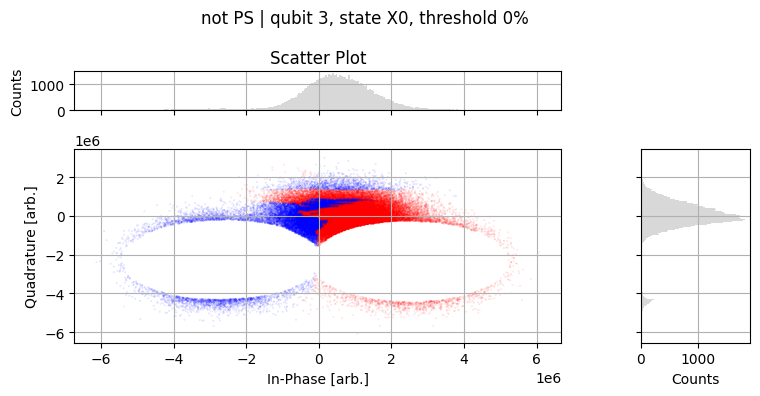

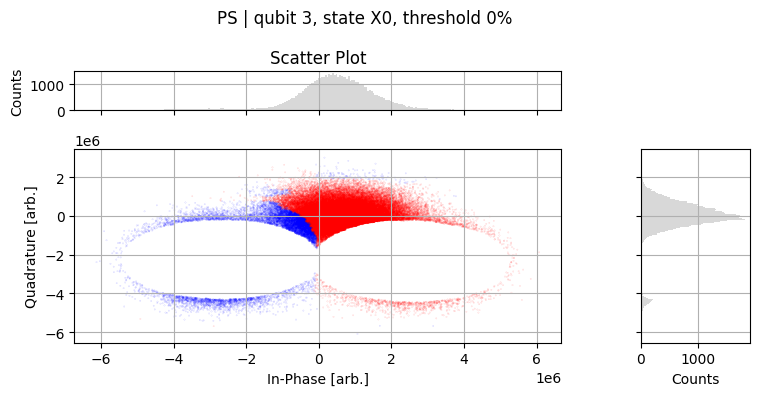

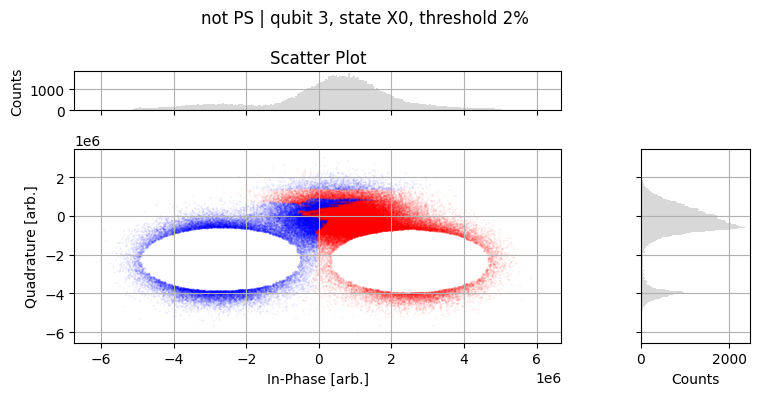

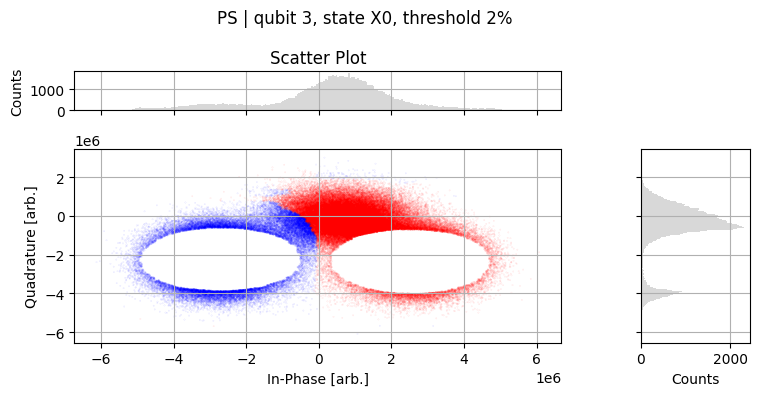

sum mask_1: 17248
sum maskPS_1: 17063
sum mask_2: 47910
sum maskPS_2: 46768


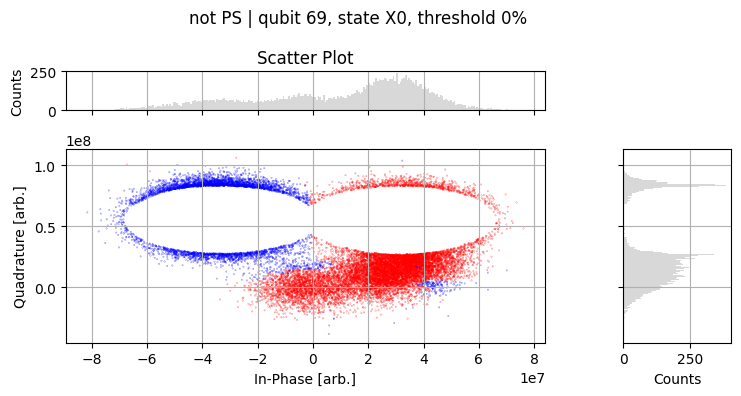

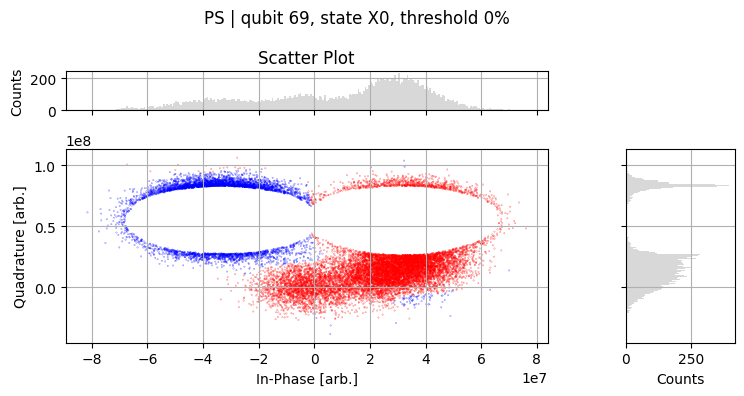

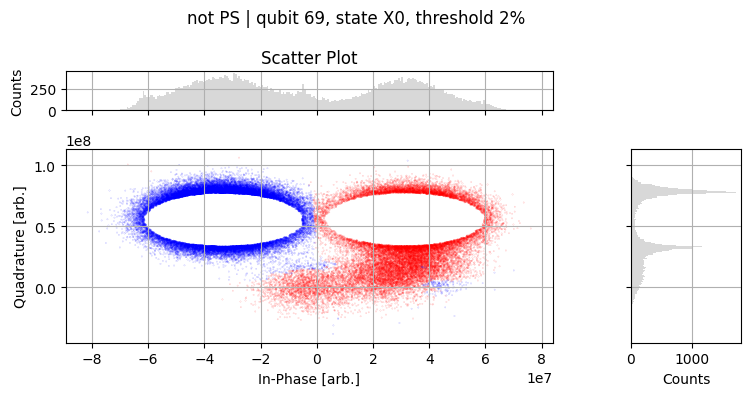

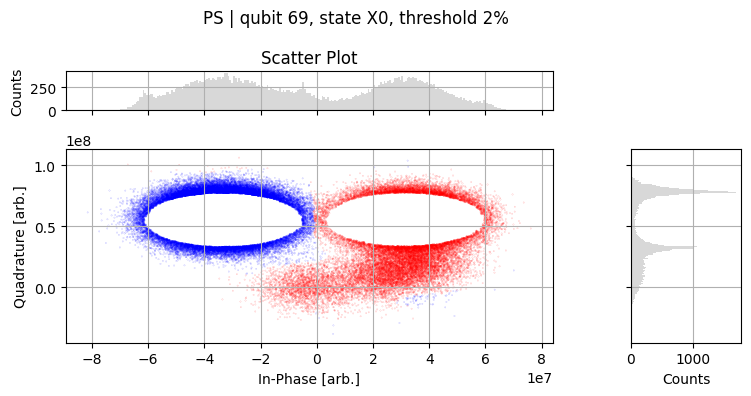

 67%|██████▋   | 8/12 [19:49<09:00, 135.25s/it]

In [2]:
logicals = ['0', '1']
xbasis = [True, False]
rounds = [50]
devices = ["ibm_sherbrooke"]

thresh1 = 0.5e-2
thresh2 = 2e-2

for DEVICE in devices:
    for LOGICAL in logicals:
        for XBASIS in xbasis:
            for ROUNDS in rounds:
                state = "X" if XBASIS else "Z"
                state += LOGICAL

                file_name  = f'./results/0.5,2-{DEVICE}_{state}_{ROUNDS}.json'

                decode(DEVICE, LOGICAL, XBASIS, ROUNDS, file_name, thresh1, thresh2)